In [6]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt

In [10]:
import cmath

def permittivity_to_refractive_index(epsilon):
    """
    복소 유전율(epsilon)을 입력받아 복소 굴절률(n + i*k)을 반환합니다.
    epsilon: 복소수 혹은 실수 형태의 유전율(예: 2.13, -7.01+0.21j 등)
    return: 복소 굴절률 n_complex = n + i*k (n_complex.real, n_complex.imag)
    """
    return cmath.sqrt(epsilon)

# 예시: 표에 주어진 물질들의 복소 유전율
materials = {
    "SiO2": 2.13,             # 실수만 있는 경우
    "Ag"  : -7.01 + 0.21j,    # 복소수(실수부가 음수)
    "GaN" : 6.18,             # 실수만 있는 경우
    "Al2O3": 3.17             # 실수만 있는 경우
}

# 각 물질에 대해 복소 굴절률 계산
for mat, eps in materials.items():
    n_complex = permittivity_to_refractive_index(eps)
    n = n_complex.real  # 실수부
    k = n_complex.imag  # 허수부
    print(f"{mat} (ε={eps}): n = {n:.3f}, k = {k:.3f}")


SiO2 (ε=2.13): n = 1.459, k = 0.000
Ag (ε=(-7.01+0.21j)): n = 0.040, k = 2.648
GaN (ε=6.18): n = 2.486, k = 0.000
Al2O3 (ε=3.17): n = 1.780, k = 0.000


In [12]:
resolution = 20
nm = 1e-3

al2o3_str_x = 100*nm
al2o3_str_y = 1070*nm

ag_str_x = 1000*nm
ag_str_y = 70*nm

sio2_str_x = 70*nm
sio2_str_y = 1070*nm

gan_str_x = 1000*nm
gan_str_y = 1000*nm

structure_x = ag_str_x + sio2_str_x*2 + al2o3_str_x*2
structure_y = al2o3_str_y

structure_size = mp.Vector3(structure_x, structure_y,0)

In [13]:
# 재료 정의(Ag의 경우는 음의 굴절률을 가지기 때문에 conductivity로 변환)
GaN = mp.Medium(epsilon=2.486)  # GaN
# Qw = mp.Medium(epsilon=)  # QW (양자 우물, GaN과 비슷하게 설정)
Ag = mp.Medium(epsilon=-7.01, D_conductivity=2*np.pi*0.45*0.101/7.01)
SiO2 = mp.Medium(epsilon=1.459)  # SiO2
Al2O3 = mp.Medium(epsilon=1.78)  # Al2O3

In [17]:
# 전체 구조 크기
structure_x = ag_str_x + 2*sio2_str_x + 2*al2o3_str_x  # 1340 nm
structure_y = al2o3_str_y                              # 1070 nm
structure_size = mp.Vector3(structure_x, structure_y, 0)

# 왼쪽 끝 ~ 오른쪽 끝을 -structure_x/2 ~ +structure_x/2로 놓고,
# 각 블록이 이어지도록 x 좌표를 순차적으로 계산
left_edge = -0.5 * structure_x  # 왼쪽 끝 x좌표 = -670 nm

# (1) 왼쪽 Al2O3
al2o3_left_center = left_edge + 0.5*al2o3_str_x  # -670 + 50 = -620 nm

# (2) 왼쪽 SiO2
sio2_left_center  = al2o3_left_center + 0.5*al2o3_str_x + 0.5*sio2_str_x
#  = -620 + 50 + 35 = -535 nm

# (3) 중앙 GaN
gan_center = sio2_left_center + 0.5*sio2_str_x + 0.5*gan_str_x
#  = -535 + 35 + 500 = 0 nm

# (4) 오른쪽 SiO2
sio2_right_center = gan_center + 0.5*gan_str_x + 0.5*sio2_str_x
#  = 0 + 500 + 35 = 535 nm

# (5) 오른쪽 Al2O3
al2o3_right_center = sio2_right_center + 0.5*sio2_str_x + 0.5*al2o3_str_x
#  = 535 + 35 + 50 = 620 nm

# 이제 geometry 리스트 구성
geometry = [
    # 왼쪽 Al2O3
    mp.Block(size=mp.Vector3(al2o3_str_x, al2o3_str_y, mp.inf),
             center=mp.Vector3(al2o3_left_center, 0),
             material=Al2O3),  # 예시로 index 지정
    
    # 왼쪽 SiO2
    mp.Block(size=mp.Vector3(sio2_str_x, sio2_str_y, mp.inf),
             center=mp.Vector3(sio2_left_center, 0),
             material=SiO2),  # 예시로 index 지정
    
    # 중앙 GaN
    mp.Block(size=mp.Vector3(gan_str_x, gan_str_y, mp.inf),
             center=mp.Vector3(gan_center, 0),
             material=GaN),   # 예시로 index 지정
    
    # QW (예: 두께 20 nm, 중앙에서 y=-480 nm 위치)
    mp.Block(size=mp.Vector3(gan_str_x, 20*nm, mp.inf),
             center=mp.Vector3(gan_center, -480*nm),
             material=mp.Medium(index=3.0)),   # 예시로 index 지정
    
    # 오른쪽 SiO2
    mp.Block(size=mp.Vector3(sio2_str_x, sio2_str_y, mp.inf),
             center=mp.Vector3(sio2_right_center, 0),
             material=SiO2),
    
    # 오른쪽 Al2O3
    mp.Block(size=mp.Vector3(al2o3_str_x, al2o3_str_y, mp.inf),
             center=mp.Vector3(al2o3_right_center, 0),
             material=Al2O3),
    
    # 맨 아래 Ag (두께 70 nm, 전체 너비 1000 nm)
    mp.Block(size=mp.Vector3(ag_str_x, ag_str_y, mp.inf),
             center=mp.Vector3(0, - (0.5*structure_y - 0.5*ag_str_y)),
             material=Ag)  # 예시로 Ag 복소 굴절률
]

In [ ]:
source = 

In [ ]:
sim = mp.Simulation(
    cell_size=structure_size,
    boundary_layers=[mp.PML(1.0)],
    geometry=geometry,
    sources = source,
    resolution=resolution
)

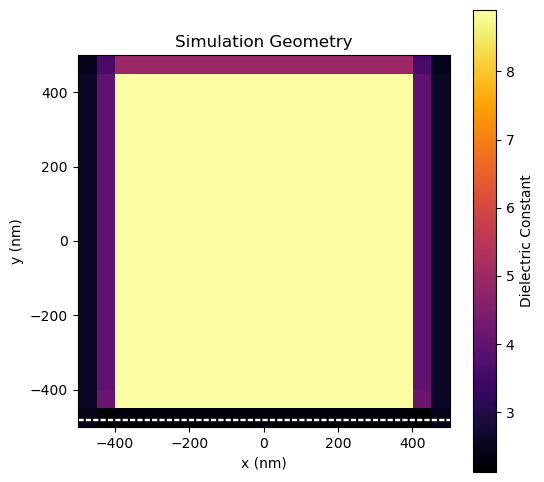

     block, center = (0,0,0)
          size (1,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (8.9,8.9,8.9)
     block, center = (0,-0.48,0)
          size (1,0.005,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (8.9,8.9,8.9)
     block, center = (0,-0.5,0)
          size (1,0.05,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (-0.465,0,0)
          size (0.07,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1,2.1,2.1)
     block, center = (0.465,0,0)
          size (0.07,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1,2.1,2.1)
     block, center = (-0.5,0,0)
          size (0.07,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.1,3.1,3.1)
     block, center = (0.5,0,0)
    

<Axes: xlabel='X', ylabel='Y'>

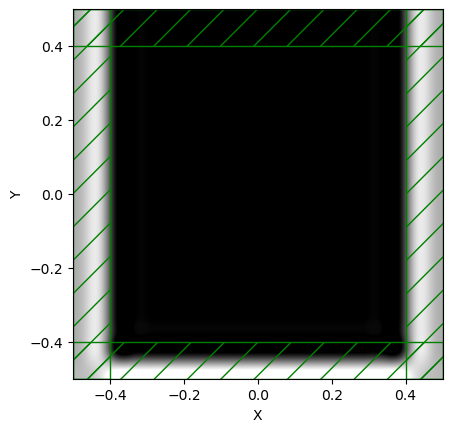

In [5]:
# 시뮬레이션 실행
sim.init_sim()

# 필드 데이터 추출 후 플로팅
def plot_simulation_geometry(sim):
    eps_data = np.array(sim.get_array(center=mp.Vector3(), size=size, component=mp.Dielectric))
    plt.figure(figsize=(6,6))
    plt.imshow(eps_data.T, origin='lower', cmap='inferno', extent=[-500, 500, -500, 500])
    plt.colorbar(label='Dielectric Constant')
    plt.xlabel("x (nm)")
    plt.ylabel("y (nm)")
    plt.title("Simulation Geometry")
    
    # QW 영역 강조 표시
    qw_y_start = (-480 * nm - 2.5 * nm) / nm
    qw_y_end = (-480 * nm + 2.5 * nm) / nm
    plt.axhline(y=qw_y_start, color='w', linestyle='--', linewidth=1)
    plt.axhline(y=qw_y_end, color='w', linestyle='--', linewidth=1)
    
    plt.show()

plot_simulation_geometry(sim)
sim.plot2D()